<a href="https://colab.research.google.com/github/ashishar/Perimeter-Institute-Mini-Course-Quantum-2024/blob/master/Variational_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install pennylane

In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem

#Variational Quantum Eigensolver

Import the molecule and coordintates (experimentally measured)

In [ ]:
symbols = ["H", "H"]
coordinates = np.array([[0,0, -0.6614], [0,0,0.6614]])

Build the Hamiltonian `H` and obtain the number of `qubits`.

In [ ]:
H, qubits = qchem.molecular_hamiltonian(symbols, coordinates)

In [ ]:
print(H)

-0.042072551947439224 * I(0) + 0.1777135822909176 * Z(0) + -0.2427450126094144 * Z(2) + 0.12293330449299361 * (Z(0) @ Z(2)) + 0.1777135822909176 * Z(1) + 0.17059759276836803 * (Z(0) @ Z(1)) + 0.044750084063019925 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.044750084063019925 * (Y(0) @ Y(1) @ X(2) @ X(3)) + -0.044750084063019925 * (X(0) @ X(1) @ Y(2) @ Y(3)) + 0.044750084063019925 * (X(0) @ Y(1) @ Y(2) @ X(3)) + -0.2427450126094144 * Z(3) + 0.16768338855601356 * (Z(0) @ Z(3)) + 0.12293330449299361 * (Z(1) @ Z(3)) + 0.16768338855601356 * (Z(1) @ Z(2)) + 0.1762766139418181 * (Z(2) @ Z(3))


In [ ]:
qubits

4

Ground state

In [ ]:
electrons = 2
hf = qml.qchem.hf_state(electrons, qubits)
hf

array([1, 1, 0, 0])

Define VQE circuit

In [ ]:
def vqe_circuit(param):

  qml.BasisState(hf, wires = range(4))
  qml.DoubleExcitation(param, wires = range(4))


Return Expectation value

In [ ]:
dev = qml.device('default.qubit', wires = qubits)

@qml.qnode(dev)
def vqe_expval(param):

  vqe_circuit(param)

  return qml.expval(H)

Run optimize routine

In [ ]:
def optimize(cost_function, init_params, steps):

  opt = qml.GradientDescentOptimizer(stepsize = 0.4) # Change this as you see fit

  params = init_params

  for i in range(steps):

    params = opt.step(cost_function, params)

  return params, cost_function(params)

In [ ]:
theta = np.array(0.0, requires_grad = True)

In [ ]:
optimize(vqe_expval, theta, 100)

(tensor(0.20973289, requires_grad=True),
 tensor(-1.13618916, requires_grad=True))

Read ground state

In [ ]:
dev = qml.device('default.qubit', wires = qubits)

@qml.qnode(dev)
def vqe_state(param):

  vqe_circuit(param)

  return qml.state()

In [ ]:
vqe_state(0.20973289)

tensor([ 0.        +0.j,  0.        +0.j,  0.        +0.j,
        -0.10467435+0.j,  0.        +0.j,  0.        +0.j,
         0.        +0.j,  0.        +0.j,  0.        +0.j,
         0.        +0.j,  0.        +0.j,  0.        +0.j,
         0.99450655+0.j,  0.        +0.j,  0.        +0.j,
         0.        +0.j], requires_grad=True)

# Quantum Approximate Optimization Algorithm

Define edges from graph

In [ ]:
edges = [(0,1),(0,2),(1,3),(1,2),(2,4),(3,4)]

Define cost and mixer Hamiltonians

In [ ]:
cost_ham= 0*qml.Identity(0)

for elem in edges:
  cost_ham = cost_ham - 0.5*qml.Identity(0)
  cost_ham = cost_ham + 0.5*qml.PauliZ(elem[0])@qml.PauliZ(elem[1])

cost_ham

(
    0 * I(0)
  + -0.5 * I(0)
  + (0.5 * Z(0)) @ Z(1)
  + -0.5 * I(0)
  + (0.5 * Z(0)) @ Z(2)
  + -0.5 * I(0)
  + (0.5 * Z(1)) @ Z(3)
  + -0.5 * I(0)
  + (0.5 * Z(1)) @ Z(2)
  + -0.5 * I(0)
  + (0.5 * Z(2)) @ Z(4)
  + -0.5 * I(0)
  + (0.5 * Z(3)) @ Z(4)
)

In [ ]:
mixer_ham = np.sum(qml.PauliX(wires = i) for i in range(5))

QAOA circuit

In [ ]:
dev = qml.device('default.qubit', wires = 5)

@qml.qnode(dev)
def qaoa_circuit(params):

  qml.broadcast(qml.Hadamard, wires = range(5), pattern = 'single')

  for i in range(len(params)):
    qml.evolve(cost_ham, coeff = params[0][i])
    qml.evolve(mixer_ham, coeff = params[1][i])

  return qml.expval(cost_ham)

Cost function and optimization


In [ ]:
def cost(params):

  return qaoa_circuit(params)

In [ ]:
def optimize(cost_function, init_params, steps):

  opt = qml.GradientDescentOptimizer(stepsize=0.1) # Change this as you see fit

  params = init_params

  for i in range(steps):

    params = opt.step(cost_function, params)

  return params, cost_function(params)

In [ ]:
 opt_params, opt_cost = optimize(cost, np.array([[0.5,0.5],[0.5,0.5]], requires_grad = True) , 120)

Compute and plot probabilities

In [ ]:
@qml.qnode(dev)
def qaoa_probs(params):

  qml.broadcast(qml.Hadamard, wires = range(5), pattern = 'single')

  for i in range(len(params)):
    qml.evolve(cost_ham, coeff = params[0][i])
    qml.evolve(mixer_ham, coeff = params[1][i])

  return qml.probs(wires = range(5))

probs = qaoa_probs(opt_params)

<ipython-input-33-6f6f4133b234>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


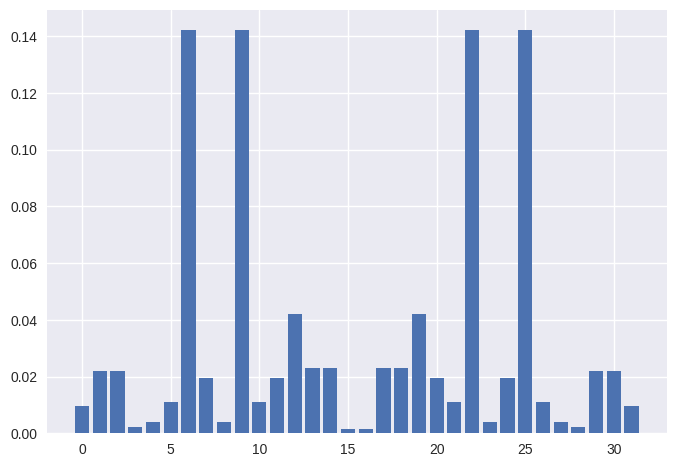

In [ ]:
from matplotlib import pyplot as plt
plt.style.use("seaborn")
plt.bar(range(2 ** 5), probs)
plt.show()